In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir("drive/MyDrive/Colab Notebooks/Authorship Identification/")

import heapq
import warnings
import numpy as np
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

random_seed = 42
np.random.seed = 42

/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load C50 Dataset (if already loaded)

- this (original dataset) is 50 train - 50 test split

In [2]:
train_df = pd.read_csv('C50/train.csv')
test_df = pd.read_csv('C50/test.csv')

- this dataset is the original one with entity names removed

In [4]:
import pandas as pd

train_df = pd.read_csv('C50/train_noents.csv')
test_df = pd.read_csv('C50/test_noents.csv')
train_df.rename(columns={'text': 'content', 'label': 'author'}, inplace=True)
test_df.rename(columns={'text': 'content', 'label': 'author'}, inplace=True)

- this is 90 train - 10 test split

In [3]:
test_frac = 0.1
train_df = pd.concat([train_df, test_df])
test_df = train_df.sample(frac=test_frac, random_state=random_seed)
train_df = train_df.drop(test_df.index)

### Load "All the News" 1 Dataset

In [18]:
test_frac = 0.15
train_df = pd.read_csv('All the News/all_the_news1_noents.csv') # or articles1.csv if want the original dataset (with named entities)
train_df = train_df[(train_df.publication == 'Breitbart')]
top10_authors = train_df[['author','id']].groupby('author').count().sort_values(by='id', ascending=False).head(10).reset_index() # this == what the paper proposed
print('The authors are', top10_authors.author.values)
train_df = pd.merge(train_df, top10_authors[['author']], on='author', how='right')
train_df = train_df.groupby(by='author').sample(500, random_state=random_seed)
test_df = train_df.sample(frac=test_frac, random_state=random_seed)
train_df = train_df.drop(test_df.index).reset_index()
test_df = test_df.reset_index()

The authors are ['Breitbart News' 'Pam Key' 'Charlie Spiering' 'Jerome Hudson'
 'John Hayward' 'Daniel Nussbaum' 'AWR Hawkins' 'Ian Hanchett'
 'Joel B. Pollak' 'Alex Swoyer']


### Preprocessing

In [19]:
le = preprocessing.LabelEncoder()
le.fit(train_df['author'])
author_names = le.classes_
train_df['author_id'] = le.transform(train_df['author']).astype(int)
test_df['author_id'] = le.transform(test_df['author']).astype(int)
y_train = train_df['author_id']
y_test = test_df['author_id']

In [20]:
train_df.head()

,index,Unnamed: 0,id,title,publication,author,date,year,month,url,content,author_id
0,6397,20138,38884,Carly Fiorina: 9th Circuit Decision Makes Defe...,Breitbart,AWR Hawkins,2016-06-11,2016.0,6.0,NaN,released a statement via email in which she sa...,0
1,6347,18597,37338,Former Assemblyman: Newsom’s Gun Control Push ...,Breitbart,AWR Hawkins,2016-04-30,2016.0,4.0,NaN,Former and current congressional candidate bel...,0
2,6111,9837,28573,Pre-Schooler Suspended for Bringing Empty .22 ...,Breitbart,AWR Hawkins,2017-03-23,2017.0,3.0,NaN,On was suspended for after bringing an empt...,0
3,6255,15584,34320,Donald Trump: I Won’t Let Politicians Disarm t...,Breitbart,AWR Hawkins,2016-02-05,2016.0,2.0,NaN,presidential hopeful used to release a new ad ...,0
4,6510,23613,42364,NRA Louisville Convention Garnered ’$53 Millio...,Breitbart,AWR Hawkins,2016-05-25,2016.0,5.0,NaN,"The ’s and , held in , , produced a “economi...",0


In [ ]:
# not used for linear models (nb, lr)
# valid_frac = 0.1 / (1 - test_frac)
# valid_df = train_df.sample(frac=valid_frac, random_state=random_seed)
# train_df = train_df.drop(valid_df.index)

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=False) #, stop_words='english')
X_train = vectorizer.fit_transform(train_df['content'])
X_test = vectorizer.transform(test_df['content'])
feat_names = vectorizer.get_feature_names_out()
feat_idf = vectorizer.idf_
X_train.shape, X_test.shape, X_train.nnz, X_test.nnz, y_train.shape, y_test.shape

((4250, 512131), (750, 512131), 2020512, 297660, (4250,), (750,))

In [22]:
tfidf_df = pd.DataFrame(np.concatenate([feat_names[:,None], feat_idf[:,None]], axis=1), 
                        columns=['feat_name', 'feat_idf']).sort_values(by='feat_idf')
tfidf_df.tail(10)

,feat_name,feat_idf
195083,favorable rating,8.661762
195082,favorable polls,8.661762
195081,favorable opinion,8.661762
195080,favorable numbers,8.661762
195079,favorable light,8.661762
195078,favorable issue,8.661762
195077,favorable impression,8.661762
195075,favorable for,8.661762
195105,favorably reversal,8.661762
512130,김태미 etammykim,8.661762


### From 11/03 Discussion: Remove Top-k IDF Words from documents

In [23]:
def calc_tokens_removed(idf_split):
    full = TfidfVectorizer(ngram_range=(1, 2), lowercase=False).build_analyzer()
    remove_words = feat_names[feat_idf >= idf_split].tolist()
    remove = TfidfVectorizer(ngram_range=(1, 2), lowercase=False, stop_words=remove_words).build_analyzer()
    full_len = train_df['content'].apply(lambda text: len(full(text))).to_numpy()
    remove_len = train_df['content'].apply(lambda text: len(remove(text))).to_numpy()
    return np.mean((full_len - remove_len)/full_len)

def remove_topk_df(train, test, percent=None, threshold=None, print_tokens=False):
    if percent is not None:
        k = int(len(feat_names) * percent)
        unmask = feat_idf.argpartition(-k)[:-k]
        threshold = max(feat_idf[unmask])
    elif threshold is not None:
        unmask = np.where(feat_idf < threshold)[0]
        percent = (len(feat_idf) - len(unmask)) / len(feat_idf)
    token_percent = calc_tokens_removed(threshold) if print_tokens else 0.
    print('{:.2%} feature types removed, >= IDF value of {:.2f} removed, {:.2%} tokens removed'.format(percent, threshold, token_percent))
    return train[:, unmask], test[:, unmask], feat_names[unmask], feat_idf[unmask]
    # diag = sparse.eye(mat.shape[1]).tolil()
    # for c in mask:
    #   diag[c, c] = 0
    # return mat.dot(diag)

In [68]:
# run this only once for testing/visualization
X_train, X_test, feat_names, feat_idf = remove_topk_df(X_train, X_test, percent=None, threshold=4, print_tokens=True)
X_train.shape, X_test.shape, feat_names.shape, feat_idf.shape

/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['AWR', 'According', 'After', 'All', 'And', 'As', 'At', 'But', 'Can', 'During', 'Follow', 'For', 'From', 'He', 'His', 'How', 'However', 'If', 'In', 'It', 'Left', 'Let', 'Mr', 'My', 'No', 'Now', 'On', 'President', 'Reach', 'Secretary', 'See', 'Sen', 'Senator', 'Senior', 'She', 'SiriusXM', 'So', 'That', 'The', 'There', 'These', 'They', 'This', 'To', 'Trump', 'Twitter', 'We', 'Well', 'What', 'When', 'While', 'You', 'able', 'about', 'according', 'across', 'action', 'actually', 'added', 'adding', 'administration', 'after', 'again', 'against', 'ahead', 'airs', 'all', 'along', 'already', 'also', 'always', 'am', 'among', 'an', 'analyst', 'and', 'announced', 'another', 'any', 'anyone', 'anything', 'appeared', 'are', 'argued', 'around', 'as', 'ask', 'asked', 'at', 'attack', 'attacks', 

99.82% feature types removed, >= IDF value of 4.00 removed, 30.30% tokens removed


((4250, 921), (750, 921), (921,), (921,))

In [69]:
tfidf_df = pd.DataFrame(np.concatenate([feat_names[:,None], feat_idf[:,None]], axis=1), 
                        columns=['feat_name', 'feat_idf']).sort_values(by='feat_idf')
tfidf_df.tail(10)

,feat_name,feat_idf
147,as he,3.988934
72,We are,3.988934
645,response to,3.988934
185,believes,3.988934
741,the Left,3.988934
765,the story,3.993617
744,the best,3.998323
49,See,3.998323
267,due,3.998323
838,victory,3.998323


### 1. Naive Bayes Classifier

In [24]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_nb = clf.predict(X_test)
feat_nb = np.exp(clf.feature_log_prob_)
feat_df_nb = pd.DataFrame(feat_names, columns=['word'])
for i in range(feat_nb.shape[0]):
    feat_df_nb[author_names[i]] = feat_nb[i,:]
feat_df_nb.head()

,word,AWR Hawkins,Alex Swoyer,Breitbart News,Charlie Spiering,Daniel Nussbaum,Ian Hanchett,Jerome Hudson,Joel B. Pollak,John Hayward,Pam Key
0,00,0.000002,0.000002,0.000003,0.000002,0.000002,0.000003,0.000002,0.000002,0.000002,0.000002
1,00 Central,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
2,00 Exit,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
3,00 Former,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
4,00 From,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002


### 2. SGD Classifier

In [25]:
clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
clf.fit(X_train, y_train)
y_sgd = clf.predict(X_test)
feat_sgd = clf.coef_
feat_df_sgd = pd.DataFrame(feat_names, columns=['word'])
for i in range(feat_sgd.shape[0]):
    feat_df_sgd[author_names[i]] = feat_sgd[i,:]
feat_df_sgd.head()

,word,AWR Hawkins,Alex Swoyer,Breitbart News,Charlie Spiering,Daniel Nussbaum,Ian Hanchett,Jerome Hudson,Joel B. Pollak,John Hayward,Pam Key
0,00,0.026739,-0.659960,1.824989,-0.255304,0.243531,5.769367e-01,-0.100226,-0.296029,-0.461353,-2.621922e-01
1,00 Central,-0.018896,-0.027877,-0.026978,-0.005759,-0.086558,-1.097827e-02,-0.012474,0.006974,-0.001599,-1.683685e-03
2,00 Exit,-0.000004,-0.002086,0.000180,-0.000012,-0.000068,-7.293122e-07,-0.000047,-0.000519,-0.000434,-7.940825e-07
3,00 Former,-0.000019,-0.018265,0.004577,-0.001189,-0.000085,-7.467126e-05,-0.014707,-0.000064,-0.003858,-4.394154e-04
4,00 From,-0.000002,-0.062126,0.017008,-0.000777,-0.000299,-7.901097e-06,-0.000613,-0.000502,-0.001624,-5.571737e-05


### Evaluate

In [26]:
def eval_all(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print('accuracy:', accuracy, '   precision:', precision, '   recall:', recall, '   f1_macro:', f1_macro)
    return accuracy, f1_macro

In [27]:
print('Naive Bayes Result')
eval_all(y_test, y_nb)
print('SGD Classifier Result')
eval_all(y_test, y_sgd)

Naive Bayes Result
accuracy: 0.468    precision: 0.8527929590934515    recall: 0.45985729400178954    f1_macro: 0.4810074725277177
SGD Classifier Result
accuracy: 0.924    precision: 0.9225351598364446    recall: 0.9273143940055851    f1_macro: 0.9223437295314796


(0.924, 0.9223437295314796)

### Grid Search in Removing Top-k IDF Words vs. Performances

In [28]:
def grid_search_idf(threshold_list, nb_path, lr_path):
    
    index_list = []
    nb_train_accs, nb_test_accs, nb_train_f1s, nb_test_f1s = [], [], [], []
    lr_train_accs, lr_test_accs, lr_train_f1s, lr_test_f1s = [], [], [], []
    
    nb_clf = MultinomialNB()
    lr_clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
    
    for threshold in threshold_list:
        
        warnings.filterwarnings(action='once')
        X_train2, X_test2, _, _ = remove_topk_df(X_train, X_test, threshold=threshold)
        nb_clf.fit(X_train2, y_train)
        lr_clf.fit(X_train2, y_train)
        y_nb_train = nb_clf.predict(X_train2)
        y_lr_train = lr_clf.predict(X_train2)
        y_nb_test = nb_clf.predict(X_test2)
        y_lr_test = lr_clf.predict(X_test2)
        nb_train_acc, nb_train_f1 = eval_all(y_train, y_nb_train)
        lr_train_acc, lr_train_f1 = eval_all(y_train, y_lr_train)
        nb_test_acc, nb_test_f1 = eval_all(y_test, y_nb_test)
        lr_test_acc, lr_test_f1 = eval_all(y_test, y_lr_test)
        
        index_list.append(threshold)
        nb_train_accs.append(nb_train_acc)
        nb_test_accs.append(nb_test_acc)
        nb_train_f1s.append(nb_train_f1)
        nb_test_f1s.append(nb_test_f1)
        lr_train_accs.append(lr_train_acc)
        lr_test_accs.append(lr_test_acc)
        lr_train_f1s.append(lr_train_f1)
        lr_test_f1s.append(lr_test_f1)
    
    nb_df = pd.DataFrame(index_list, columns=['idf_threshold'])
    nb_df['train_accs'] = nb_train_accs
    nb_df['train_f1s'] = nb_train_f1s
    nb_df['test_accs'] = nb_test_accs
    nb_df['test_f1s'] = nb_test_f1s
    nb_df['model_name'] = 'nb'
    nb_df.to_csv(nb_path + '.csv', index=False)
    
    lr_df = pd.DataFrame(index_list, columns=['idf_threshold'])
    lr_df['train_accs'] = lr_train_accs
    lr_df['train_f1s'] = lr_train_f1s
    lr_df['test_accs'] = lr_test_accs
    lr_df['test_f1s'] = lr_test_f1s
    lr_df['model_name'] = 'lr'
    lr_df.to_csv(lr_path + '.csv', index=False)
    return (nb_train_accs, nb_train_f1s, nb_test_accs, nb_test_f1s), (lr_train_accs, lr_train_f1s, lr_test_accs, lr_test_f1s)

def plot_idf(nb_path, lr_path, bert_path):
    nb_df = pd.read_csv(nb_path + '.csv')
    lr_df = pd.read_csv(lr_path + '.csv')
    bert_df = pd.read_csv(bert_path + '.csv')
    threshold_list = nb_df['idf_threshold']
    metric_ls = [('nb', nb_df['train_accs'], nb_df['test_accs'], nb_df['train_f1s'], nb_df['test_f1s']), 
                 ('lr', lr_df['train_accs'], lr_df['test_accs'], lr_df['train_f1s'], lr_df['test_f1s']),
                 ('bert', bert_df['train_accs'], bert_df['test_accs'], bert_df['train_f1s'], bert_df['test_f1s'])]
    category_colors = plt.get_cmap('brg')(np.linspace(0., 1., len(metric_ls)))
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs.flatten()
    for (metric_name, train_acc, test_acc, train_f1, test_f1), color in zip(metric_ls, category_colors):
        axs[0].plot(threshold_list, train_acc, color=color, linestyle='dashed')
        axs[0].plot(threshold_list, test_acc, color=color, linestyle='solid', label=metric_name + ' accuracy')
        axs[0].set_xlabel('IDF threshold')
        axs[0].set_ylabel('accuracy')
        axs[0].legend()
        
        axs[1].plot(threshold_list, train_f1, color=color, linestyle='dashed')
        axs[1].plot(threshold_list, test_f1, color=color, linestyle='solid', label=metric_name + ' F1 score')
        axs[1].set_xlabel('IDF threshold')
        axs[1].set_ylabel('F1 score')
        axs[1].legend()
    plt.show()

In [29]:
grid_search_idf(threshold_list=np.arange(10., 1., -0.5), nb_path='All the News/result/nb_model', lr_path='All the News/result/lr_model')

0.00% feature types removed, >= IDF value of 10.00 removed, 0.00% tokens removed
accuracy: 0.7945882352941176    precision: 0.9283182779188446    recall: 0.794547784260548    f1_macro: 0.8269586544272371
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.468    precision: 0.8527929590934515    recall: 0.45985729400178954    f1_macro: 0.4810074725277177
accuracy: 0.924    precision: 0.9225351598364446    recall: 0.9273143940055851    f1_macro: 0.9223437295314796
0.00% feature types removed, >= IDF value of 9.50 removed, 0.00% tokens removed
accuracy: 0.7945882352941176    precision: 0.9283182779188446    recall: 0.794547784260548    f1_macro: 0.8269586544272371
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.468    precision: 0.8527929590934515    recall: 0.45985729400178954    f1_macro: 0.4810074725277177
accuracy: 0.924    precision: 0.9225351598364446    recall: 0.9273143940055851    f1_macro: 0.9223437295314796
0.00% feature types

/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(([0.7945882352941176,
   0.7945882352941176,
   0.7945882352941176,
   0.756,
   0.7574117647058823,
   0.7816470588235294,
   0.8068235294117647,
   0.8378823529411765,
   0.8496470588235294,
   0.8614117647058823,
   0.8585882352941177,
   0.8574117647058823,
   0.8374117647058823,
   0.7847058823529411,
   0.6694117647058824,
   0.5731764705882353,
   0.4430588235294118,
   0.2348235294117647],
  [0.8269586544272371,
   0.8269586544272371,
   0.8269586544272371,
   0.7944054510244805,
   0.7944173635837132,
   0.8129709762450655,
   0.8310543331395246,
   0.853797427533267,
   0.8602443247614293,
   0.8676938779036647,
   0.8615520274575429,
   0.8595249819825842,
   0.8390019930427165,
   0.7842738601166974,
   0.6642090428362563,
   0.5571255075863001,
   0.4048307790388897,
   0.16894934685791937],
  [0.468,
   0.468,
   0.468,
   0.516,
   0.5506666666666666,
   0.6013333333333334,
   0.656,
   0.7173333333333334,
   0.7653333333333333,
   0.7906666666666666,
   0.816,
   0.809

In [30]:
plot_idf(nb_path='All the News/result/nb_model', lr_path='All the News/result/lr_model', 
         bert_path='All the News/result/bert_uncased_epoch15_lr2e-5_batch16')

FileNotFoundError: [Errno 2] No such file or directory: 'All the News/result/bert_uncased_epoch15_lr2e-5_batch16.csv'

### Get TF-IDF Feat Values

In [73]:
def get_tfidf_feat(feat_df, feat_data, author_name, top_k=5, larger=True):
    idxs = feat_df.index[feat_df['author'] == author_name].tolist()
    feat_val = feat_data[idxs]
    word_val = feat_names
    n = feat_val.shape[0]
    word_array = []
    val_array = []
    for i in range(n):
        val_col = feat_val[i].toarray()[0]
        idxs = np.argsort(val_col)[-top_k:][::-1] if larger else np.argsort(val_col)[top_k:]
        words = word_val[idxs]
        vals = val_col[idxs]
        word_array.append(words)
        val_array.append(vals)
    word_array = np.array(word_array)
    val_array = np.array(val_array)
    sorted_idxs = np.argsort(-val_array.sum(axis=1))
    return word_array[sorted_idxs], val_array[sorted_idxs]

In [74]:
word_tfidf, val_tfidf = get_tfidf_feat(train_df, X_train, author_name='AWR Hawkins', top_k=5)

### Feature Importance Extraction

In [75]:
def get_feat_importance(feat_df, word_col, author_cols, top_k=5, larger=True):
    n = feat_df.shape[0]
    word_array = []
    val_array = []
    for author_col in author_cols:
        val_col = feat_df[author_col].values.take
        idxs = heapq.nlargest(top_k, range(n), val_col) if larger else heapq.nsmallest(top_k, range(n), val_col)
        words = feat_df[word_col][idxs]
        vals = feat_df[author_col][idxs]
        word_array.append(words)
        val_array.append(vals)
    word_array = np.array(word_array)
    val_array = np.array(val_array)
    return word_array, val_array
    # sorted_idxs = np.argsort(-val_array.sum(axis=1))
    # return word_array[sorted_idxs], val_array[sorted_idxs]

In [76]:
word_array_nb, val_array_nb = get_feat_importance(feat_df_nb, 'word', author_names, top_k=5)
word_array_sgd, val_array_sgd = get_feat_importance(feat_df_sgd, 'word', author_names, top_k=5)

### Feature Importance Visualization

In [77]:
def plot_feat_importance(word_array, val_array, author_cols, ycol_name):
    n, k = word_array.shape
    val_cum = val_array.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.25, 0.75, val_array.shape[1]))
    fig, ax = plt.subplots(figsize=(k*6, n//2))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(val_array, axis=1).max())
    for i, color in enumerate(category_colors):
        widthnames = word_array[:, i]
        widths = val_array[:, i]
        starts = val_cum[:, i] - widths
        ax.barh(author_cols, widths, left=starts, height=0.8, color=color)
        xcenters = starts + widths / 2
        for y, (x, name, val) in enumerate(zip(xcenters, widthnames, widths)):
            ax.text(x, y, name + ': ' + '{:.2f}'.format(val), ha='center', va='center', color='black')
    plt.ylabel(ycol_name)
    plt.title('top-' + str(k) + ' important word: importance values')
    plt.show()

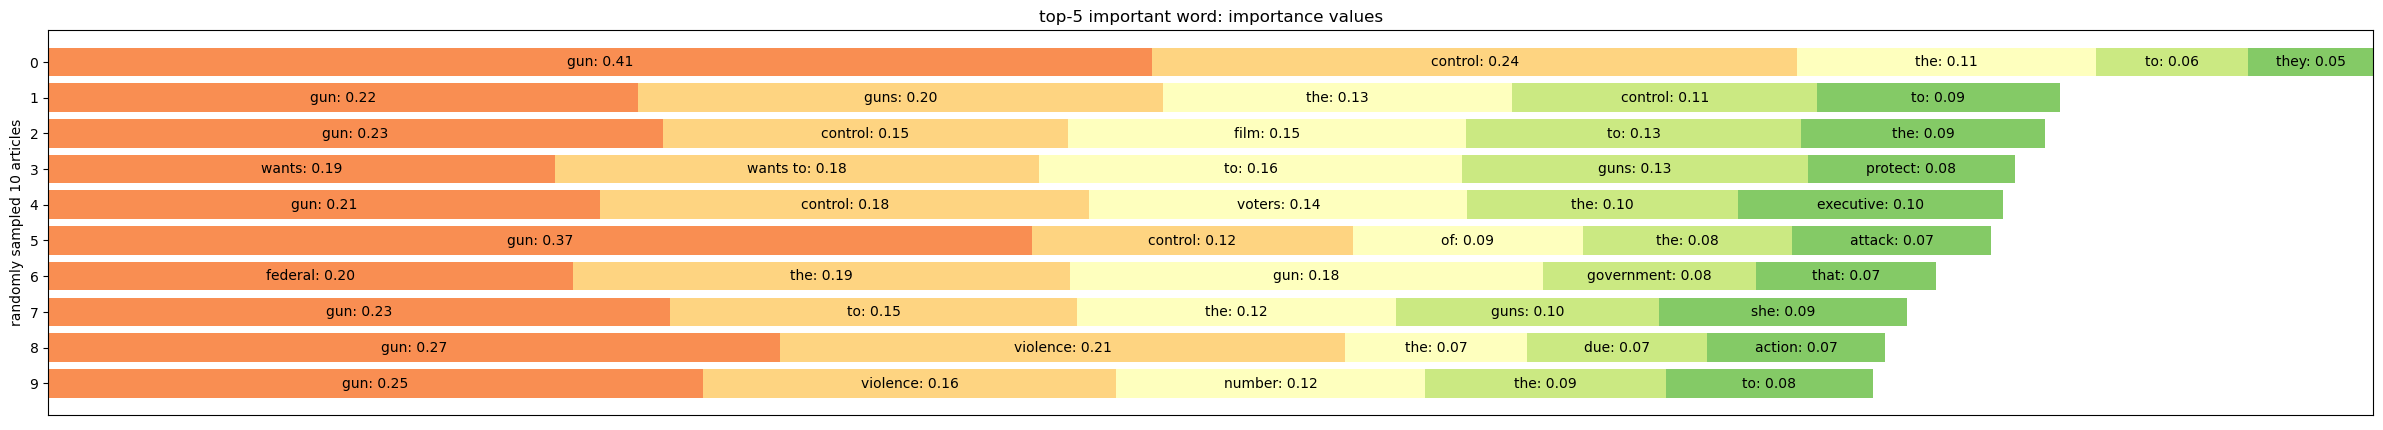

In [78]:
plot_feat_importance(word_tfidf[:10], val_tfidf[:10], [str(i) for i in range(10)], 'randomly sampled 10 articles')

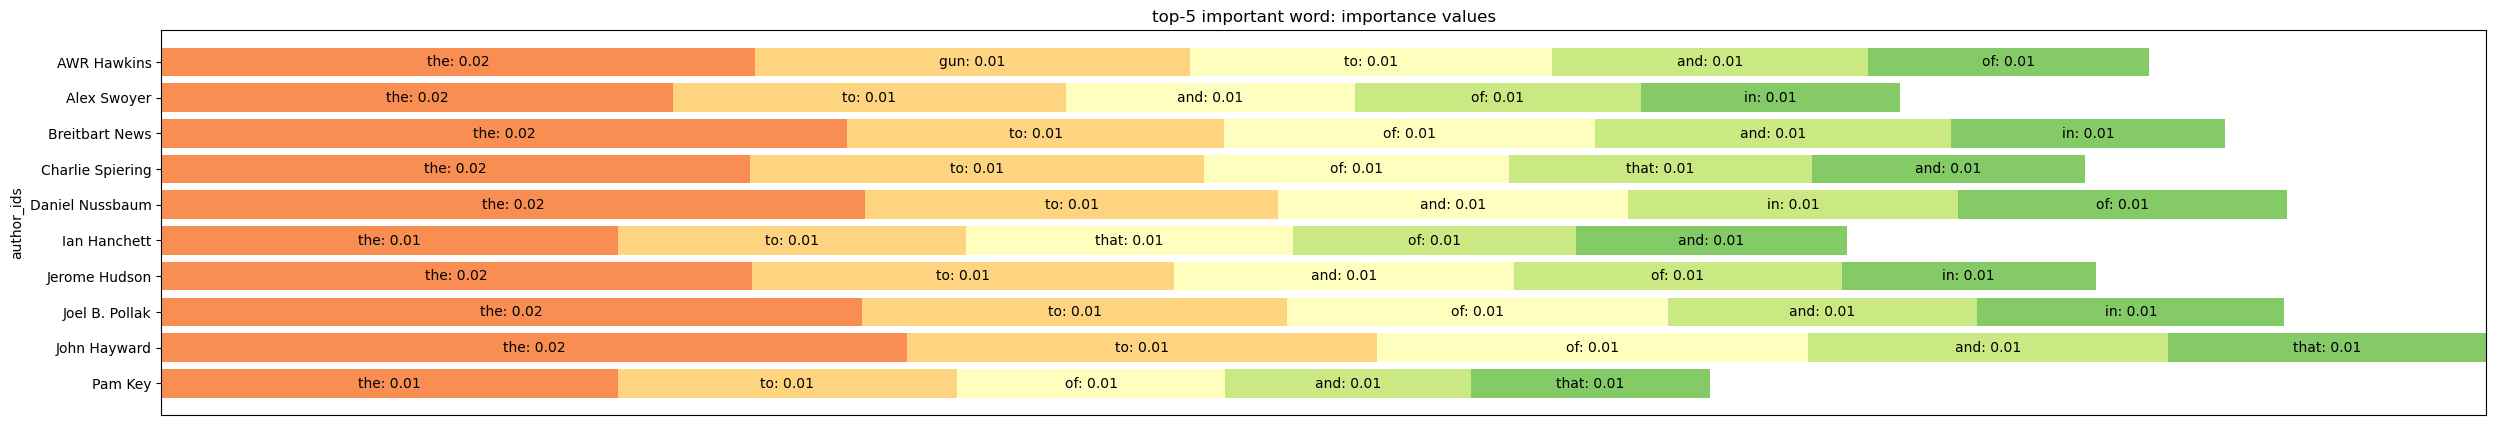

In [79]:
plot_feat_importance(word_array_nb[:10], val_array_nb[:10], author_names[:10], 'author_ids')

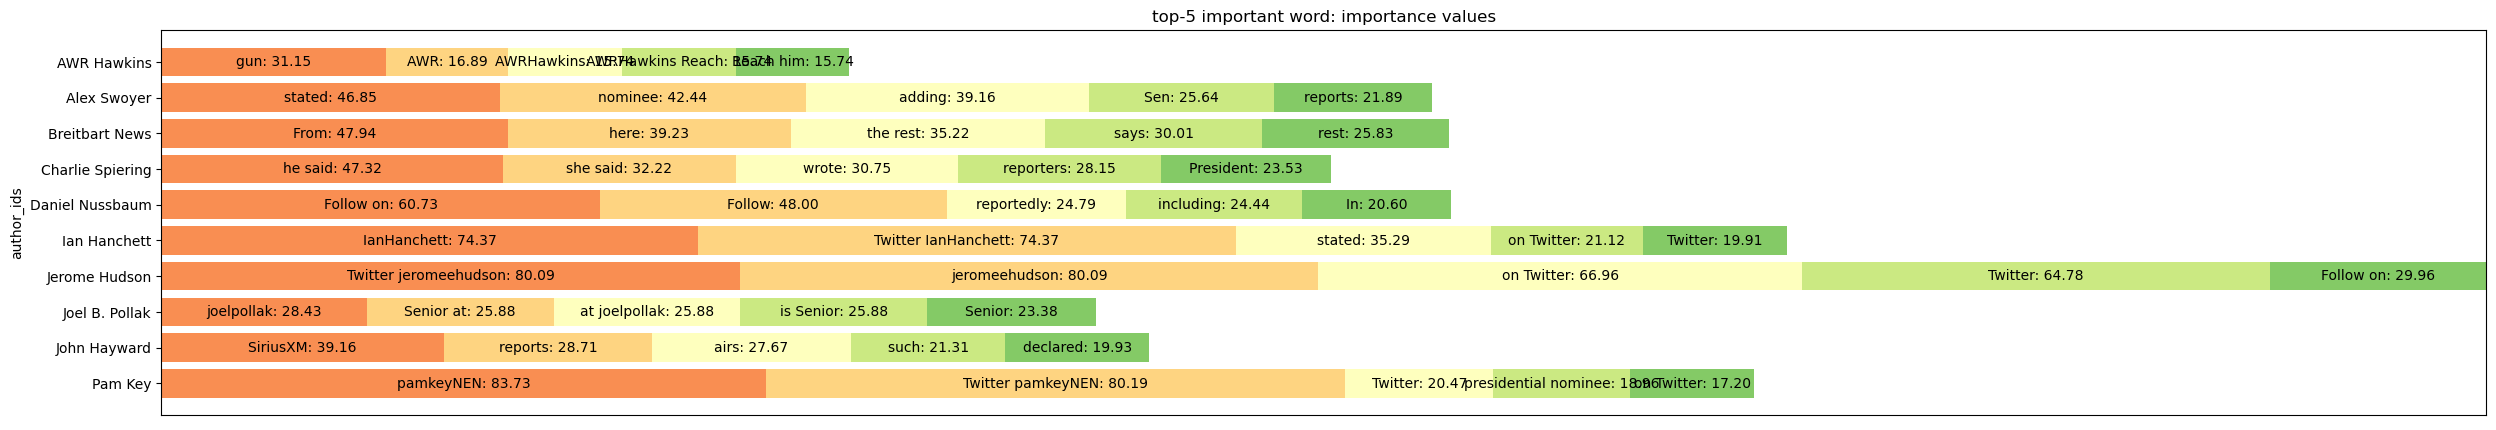

In [80]:
plot_feat_importance(word_array_sgd[:10], val_array_sgd[:10], author_names[:10], 'author_ids')

### Test on the random seed

In [ ]:
acc = []
f1 = []
for i in range(1000):
    random_seed = i
    clf = SGDClassifier(loss='log', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
    clf.fit(X_train, y_train)
    y_sgd = clf.predict(X_test)
    accuracy, f1_macro = eval_all(y_test, y_sgd)
    acc.append(accuracy)
    f1.append(f1_macro)

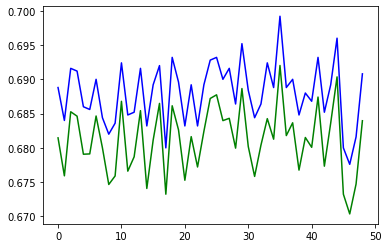

In [ ]:
plt.plot(range(49), acc, 'b')
plt.plot(range(49), f1, 'g')
plt.show()